### 추천 시스템 제작(Pinterest), CPU

In [21]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
# import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/dnn/recommend_book' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------

In [22]:
# header가 있을경우 skiprows=1 선언
data = np.loadtxt('./train.csv', delimiter=',', skiprows=1, dtype=np.float64)   # 특성이 작은 데이터의 예외 추가, 손실: 0.0060576219111680984
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(220, 50)


In [23]:
# 데이터와 class의 분리
# 0: 강아지, 1: 카페, 2: 가을, 3: 한우, 4: 꽃
X = data[:, 0:49]  # 0 ~ 49
print(X.shape)
Y = data[:, 49]    # 49 번째 데이터, class의 분리
print(Y.shape)

(220, 49)
(220,)


In [24]:
print(X[:5]) # 5행 확인

[[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
  0.]]


In [25]:
print(Y[:5]) # 5행의 데이터만 확인

[0. 1. 2. 3. 4.]


In [26]:
Y = Y.astype('int') # 정수로 형변환
print(Y)

[0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1
 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3
 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5
 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0
 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2
 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 0 0 0 0 0 0 0 0 0]


In [27]:
# 0: 강아지, 1: 카페, 2: 가을, 3: 한우, 4: 꽃
Y_encoded = to_categorical(Y) # 데이터 전처리 기법: one-hot-encoding

print(Y_encoded[:5]) 
# [[1. 0. 0. 0. 0.]: 0 <- 숫자 1이 존재하는 index
#  [0. 1. 0. 0. 0.]: 1
#  [0. 0. 1. 0. 0.]: 2
#  [0. 0. 0. 1. 0.]: 3
#  [0. 0. 0. 0. 1.]]: 4

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]


In [28]:
print(X[0], '->', Y_encoded[0]) 
# [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
# 0.] 이 데이터는 답이 [1. 0. 0. 0. 0.] 임

print(X[1], '->', Y_encoded[1]) 
# [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
# 0.] 이 데이터는 답이 [0. 1. 0. 0. 0.]임

print(X[2], '->', Y_encoded[2]) 
# [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
# 0.]이 데이터는 답이 [0. 0. 1. 0. 0.]임

[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0.] -> [1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0.] -> [0. 1. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0.] -> [0. 0. 1. 0. 0. 0. 0.]


In [29]:
# train_test_split 분할을 통한 훈련, 검증, 테스트 데이터의 분리
seed = 0
# X 분할: x_train_all, x_test
# Y 분할: y_train_all, y_test
# stratify=Y_encoded: 5개의 그룹을 균등하게 분포시켜 분할함.
# test_size=0.1: 10%를 x_test, y_test에 할당
# random_state=seed: 무작위로 데이터 추출

# 90%: x_train_all, y_train_all
# 10%: x_test, y_test
# 테스트의 크기가 분류 갯수보다 작으면 에러가 발생함으로 5건 이상이어야함.
x_train_all, x_test, y_train_all, y_test = train_test_split(X, Y_encoded,
                                           stratify=Y_encoded,
                                           test_size=0.1,
                                           random_state=seed)

# 나머지 데이터 90%를 분할, 80%: 훈련, 20%: 검증
# 80%: x_train, y_train
# 20%: x_val, y_val
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                           stratify=y_train_all,
                                           test_size=0.2,
                                           random_state=seed)

print(y_val)
print(y_val.shape)
# 강아지, 고양이, 물고기, 자전거, 축제, 등산, 캠핑

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
(40, 7)


In [30]:
print(y_test)
print(y_test.shape)
# (10, 5): 10건의 데이터가 입력되어 한건당 5가지에 속할 확률이 출력됨으로 10행 5열이됨.

[[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]
(22, 7)


In [31]:
# 네트워크 구성
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed, 가중치, 편향이 일정하게 변경됨
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()
# input_dim=25: 입력 데이터 x의 갯수
model.add(Dense(20, input_dim=49, activation='relu'))# Weight: 500, BIAS: 20
model.add(Dense(10, activation='relu')) 
model.add(Dense(7, activation='softmax')) # 0 ~ 1 사이의 확률 5개 출력,총합: 1
model.compile(optimizer='adam', loss='categorical_crossentropy', 
                                metrics=['accuracy'])
model.summary()

# 오차 감소시마다 h5 형식으로 파일 저장
mcp = ModelCheckpoint(filepath='./Pinterest.h5', monitor='val_accuracy',
                      verbose=1, save_best_only=True)

# 오차가 1회 증가시 자동 종료
es = EarlyStopping(monitor='loss', patience=1, restore_best_weights=True)

hist = model.fit(x_train, y_train, 
                 validation_data=(x_val, y_val),
                 epochs=10, 
                 batch_size=1, callbacks=[mcp, es])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                1000      
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 7)                 77        
                                                                 
Total params: 1,287
Trainable params: 1,287
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
150/158 [===========================>..] - ETA: 0s - loss: 1.7957 - accuracy: 0.4867
Epoch 1: val_accuracy improved from -inf to 0.82500, saving model to .\Pinterest.h5
158/158 [==============================] - 2s 8ms/step - loss: 1.7843 - accuracy: 0.4937 - val_loss: 1.4720 - val_accuracy: 0.8250
Epoch

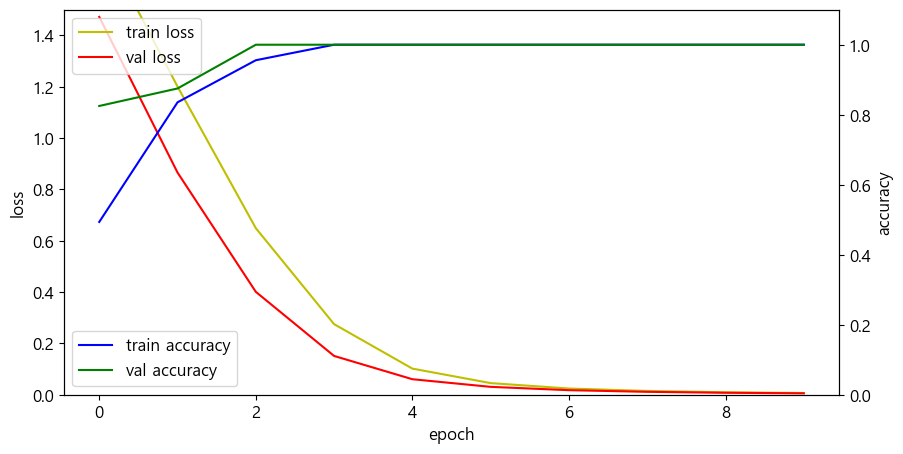

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.5]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.1])

# 축 레이블 설정
loss_ax.set_xlabel('epoch' )  # 학습 횟수
loss_ax.set_ylabel('loss')    # 왼쪽 y 축 레이블, 오차
acc_ax.set_ylabel('accuracy') # 오른쪽 y 축 레이블,정확도

loss_ax.legend(loc='upper left') # 왼쪽 y 축 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 오른쪽 y 축 정확도 레이블 위치

plt.show()

In [33]:
test_loss, test_acc = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.005481325089931488 /정확도: 100.0 %


In [34]:
# model.save(path + '/Pinterest.h5')

In [35]:
print('데이터:', x_test.shape) # 변수가 25개로 구성된 10건의 관측치(행)
print('데이터:', x_test[0])    # 첫번째 데이터행

p = model.predict(x_test)      # 테스트 데이터 10건 ★
print('예측 결과 p.shape:', p.shape)     # (10, 5): 5: 카테고리(폼종)의 갯수

데이터: (22, 49)
데이터: [0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0.]
예측 결과 p.shape: (22, 7)


In [36]:
# 첫번째 행의 예측값 출력, 확률 0 ~ 1사이의 실수값
print('예측값:', p[0])   

예측값: [6.05095585e-04 9.95720327e-01 3.62485996e-04 1.76516257e-03
 1.44451005e-05 7.60879338e-05 1.45636476e-03]


In [37]:
# 예측값의 합:1 -> 100%
print('예측값의 합: {0:0.3f}'.format(np.sum(p[0])))

예측값의 합: 1.000


In [38]:
# 하나의 행이 속할 카테고리는 5건이고 예측값도 5건에 속할 확률이 출력됨.
print('예측값: {0:.5f}% {1:.5f}% {2:.5f}% {3:.5f}% {4:.5f}'.format(p[0,0]*100,p[0,1]*100,p[0,2]*100,p[0,3]*100,p[0,4]*100))

예측값: 0.06051% 99.57203% 0.03625% 0.17652% 0.00144


In [39]:
print('One-hot-encoding(찾아야할 값): ', y_test[0])
print(np.argmax(p[0])) # 가장 큰값의 index ★

One-hot-encoding(찾아야할 값):  [0. 1. 0. 0. 0. 0. 0.]
1


In [40]:
print(p) # 10건의 모든 예측값 출력

[[6.05095585e-04 9.95720327e-01 3.62485996e-04 1.76516257e-03
  1.44451005e-05 7.60879338e-05 1.45636476e-03]
 [1.66644477e-05 1.80501700e-03 9.94873464e-01 1.38583715e-07
  1.84872781e-03 1.43150194e-03 2.44767780e-05]
 [6.05095585e-04 9.95720327e-01 3.62485996e-04 1.76516257e-03
  1.44451005e-05 7.60879338e-05 1.45636476e-03]
 [9.96422708e-01 5.71597411e-05 3.09280513e-05 8.15699343e-04
  2.66073766e-04 2.40730122e-03 1.69245862e-08]
 [5.20255824e-04 1.28783417e-04 4.05449136e-05 9.97021139e-01
  1.62952975e-03 6.16168603e-04 4.35130278e-05]
 [5.72526778e-06 1.94642972e-03 2.64265668e-03 1.10525158e-04
  1.47645478e-04 1.96770543e-05 9.95127439e-01]
 [1.66644477e-05 1.80501700e-03 9.94873464e-01 1.38583715e-07
  1.84872781e-03 1.43150194e-03 2.44767780e-05]
 [1.66644477e-05 1.80501700e-03 9.94873464e-01 1.38583715e-07
  1.84872781e-03 1.43150194e-03 2.44767780e-05]
 [1.37912040e-03 2.91050703e-04 1.00276130e-03 2.75448547e-04
  3.02029279e-04 9.96728063e-01 2.15493001e-05]
 [5.202558